# COMP42115: Natural Language Analysis
## Sumative Assesment: Sentiment Analysis Model

In [160]:
# importing the nescessary libraies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn


%matplotlib inline

from bs4 import BeautifulSoup
import re
import string
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from scipy.sparse import csr_matrix
import torch

### Data preprocessing

In [161]:
# random seed
seed = 555

In [162]:
# loading the dataset
body = pd.read_csv('data/train_bodies.csv')
stance = pd.read_csv('data/train_stances.csv')

In [163]:
print(stance.shape)
stance.head()

(49972, 3)


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [164]:
print(body.shape)
body.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [165]:
# merging the dataset
def merge_stance_body(stance, body):
    merged_data = pd.merge(stance, body, on='Body ID')
    return merged_data

df = merge_stance_body(stance, body)

In [166]:
# spliting the data into train, test and validation
train, test = train_test_split(df, test_size=0.30, random_state=seed)
train, val = train_test_split(train, test_size=0.20, random_state=seed)

In [167]:
print(train.shape)
train.head()

(27984, 4)


,Headline,Body ID,Stance,articleBody
23952,Media outlets identify 'Jihadi John',1346,discuss,THE ISLAMIC State murderer dubbed 'Jihadi John...
34151,"Rats at Vogue's NYC offices - watch your step,...",2498,agree,"In case you missed it, Vogue Magazine, one of ..."
33468,US drones hunt Isis leader in Syria,2443,discuss,There have been reports of predator drones bei...
43150,Apple Watch Gold Edition may cost as much as $...,2471,unrelated,Gill Rosenberg is reported to have been captur...
36227,HBO and Apple in Talks for $15/Month Apple TV ...,516,unrelated,A married Russian TV star woke up one day to d...


In [168]:
print(val.shape)
val.head()

(6996, 4)


,Headline,Body ID,Stance,articleBody
16486,US officials: Video shows American's execution,298,unrelated,Although Canadian police have not released the...
33030,Isilkulskom student has gained superhero power...,1503,unrelated,The internet is buzzing this morning with news...
18150,Iraqi social-media rumors claim IS leader slain,1631,unrelated,This is Sergeant-at-Arms Kevin Vickers who rep...
24707,Report: Israeli-Canadian woman fighting Islami...,2002,unrelated,BAGHDAD — Three hundred Iraqi soldiers died in...
2712,Pope Francis turns out not to have made pets i...,1905,disagree,NEW YORK — Pope Francis has given hope to gays...


In [169]:
print(test.shape)
test.head()

(14992, 4)


,Headline,Body ID,Stance,articleBody
38740,Militant Group Says It Killed American Journal...,2261,unrelated,From the midweek edition of the Morning Jolt:\...
13806,"Michael Zehaf-Bibeau, slain Ottawa shooter, ha...",186,unrelated,The sound of 10 or 11 shots from the gun of Fe...
7047,REPORT: Alleged New Audio of Michael Brown Sho...,345,unrelated,"UTAH COUNTY — Over the years, holiday office C..."
14746,Kim Jong-un Broke Both Ankles and Is Hospitali...,859,discuss,Kim Jong-Un had ankle surgery and is now recov...
49782,Report: Amazon to Launch Ad-Supported Streamin...,2442,unrelated,Google leased all 1.9 million square feet of M...


In [170]:
# spliting the data into X, Y
def split(data):
    X = data.drop(['Body ID','Stance'], axis=1)
    Y = data['Stance']
    return X,Y

X_train, Y_train = split(train)
X_val, Y_val = split(val)
X_test, Y_test = split(test)

In [171]:
# cleaning texts
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n','')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = remove_stopwords(text)
    return text

In [172]:
def clean_data(data):
    data['Headline'] = [clean_text(i) for i in data['Headline']]
    data['articleBody'] = [clean_text(i) for i in data['articleBody']]
    return data

X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [173]:
X_train.head()

,Headline,articleBody
23952,media outlets identify jihadi john,islamic state murderer dubbed jihadi john name...
34151,rats vogues nyc offices watch step anna wintour,case missed vogue magazine glamorous instituti...
33468,drones hunt isis leader syria,reports predator drones launched iraq reports ...
43150,apple watch gold edition cost 5000,gill rosenberg reported captured women fightin...
36227,hbo apple talks 15month apple tv streaming ser...,married russian tv star woke day discover test...


### Task 1 preparation

unrelated    20460
discuss       4993
agree         2057
disagree       474
Name: Stance, dtype: int64

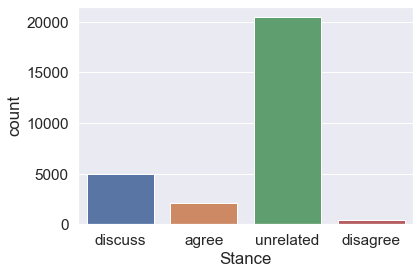

In [174]:
# plotting out the classes
sn.countplot(data=train, x='Stance')
train['Stance'].value_counts()

In [175]:
# replacing agree, disagree, and discuss with related
def get_relation(y):
    related = {'agree': 1,
               'discuss': 1,
               'disagree': 1,
               'unrelated': 0}
    y = y.replace(related)
    return y

Y_train = get_relation(Y_train)
Y_val = get_relation(Y_val)
Y_test = get_relation(Y_test)

0    20460
1     7524
Name: Stance, dtype: int64

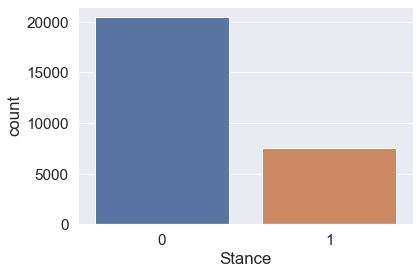

In [176]:
# plotting out the modified classes
sn.countplot(x=Y_train)
Y_train.value_counts()

In [177]:
# using random under samplier to resample the dataset
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

0    7524
1    7524
Name: Stance, dtype: int64

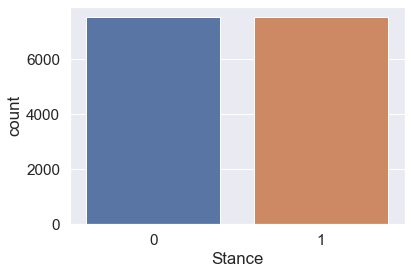

In [178]:
# checking for classes count again
sn.countplot(x=Y_train)
Y_train.value_counts()

### TFIDF vecterisation

In [180]:
# training tfidf vectoriser
tfidf_vec = pd.concat([X_test['articleBody'], X_train['articleBody']])
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2, max_features=500)
tfidf.fit(tfidf_vec)

TfidfVectorizer(decode_error='ignore', max_features=500, min_df=2)

In [181]:
# selecting random words from tfidf dictionary
dictionary = np.asarray(tfidf.get_feature_names())
print(dictionary[np.random.randint(0,len(dictionary),size=50)])

['state' 'groups' 'woods' 'appears' 'came' 'september' 'arrested' 'staff'
 'known' 'york' 'officer' 'comment' 'children' 'staff' 'claim' 'they'
 'carried' 'wanted' 'amazon' 'wearing' 'blumenthal' 'later' '20'
 'hostages' 'dog' 'kobani' 'woods' 'spoke' 'he' 'caught' 'second'
 'possible' 'called' 'middle' 'white' 'president' 'held' 'youtube'
 'interview' 'love' 'daily' 'media' 'launch' 'took' 'man' 'air'
 'statement' 'francis' 'mosul' 'rumors']


C:\Users\Ice\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [182]:
# transfroming data into vectors by stacking 2 tfidfs vectors, to differentiate headline from body
def stack_tfidf(X):
    header_tfidf = tfidf.transform(X['Headline'].values.astype('U'))
    body_tfidf = tfidf.transform(X['articleBody'].values.astype('U'))
    stacked_tfidf = hstack([header_tfidf, body_tfidf])
    return stacked_tfidf

X_train_tfidf = stack_tfidf(X_train)
X_val_tfidf = stack_tfidf(X_val)
X_test_tfidf = stack_tfidf(X_test)

In [183]:
tfidf_size = X_test_tfidf.shape
print('tfidf_size:', tfidf_size)

tfidf_size: (14992, 1000)


### preparting the scoring model

In [24]:
# creating the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

In [25]:
# creating the ROC Curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### a.1.1: TDIF-SVM

In [26]:
# building the SVM model
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model.fit(X_train_tfidf, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

In [27]:
# gridsearch parameter results
model.best_params_

{'C': 10, 'gamma': 1}

In [28]:
model = model.best_estimator_

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10956
           1       0.91      0.96      0.94      4036

    accuracy                           0.97     14992
   macro avg       0.95      0.97      0.96     14992
weighted avg       0.97      0.97      0.97     14992



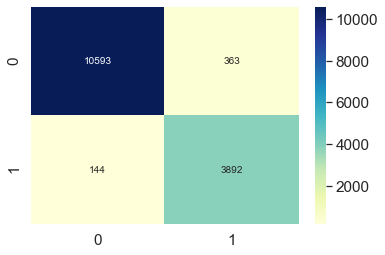

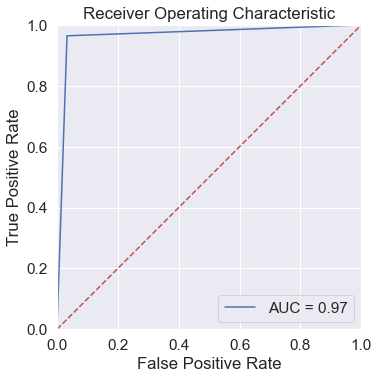

In [29]:
# predicting the test data
Y_svm = model.predict(X_test_tfidf)
print(metrics.classification_report(Y_test, Y_svm))
plot_confussion_matrix(Y_test, Y_svm)
plot_roc_curve(Y_test, Y_svm)

### a.2.1: TFIDF-LSTM

In [184]:
# preparing the input to match the dimesionality of the LSTM cells
def prepare_lstm(X, Y):
    X = X.toarray()
    X = X[:, None, :]
    Y = np.array(Y)
    return X, Y

X_train_tfidf, Y_train = prepare_lstm(X_train_tfidf, Y_train)
X_val_tfidf, Y_val = prepare_lstm(X_val_tfidf, Y_val)
X_test_tfidf, Y_test = prepare_lstm(X_test_tfidf, Y_test)

In [31]:
# input now transformed into 3-d array
X_train_tfidf.shape

(15048, 1, 1000)

In [32]:
Y_train.shape

(15048,)

In [33]:
# creating an lstm model on Keras without the embedding layer
# the model bypass the embedding layer and take input directly from the tfidf vecter
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model2 = keras.models.Sequential()
model2.add(keras.layers.LSTM(1000,
                            input_shape=(None, 1000),
                            return_sequences=True))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
model2.fit(X_train_tfidf, Y_train, 
           validation_data=(X_val_tfidf, Y_val),
           epochs=5, batch_size=8, verbose=1)

Epoch 1/5
1881/1881 [==============================] - 56s 30ms/step - loss: 0.5849 - accuracy: 0.6750 - val_loss: 0.4017 - val_accuracy: 0.8129
Epoch 2/5
1881/1881 [==============================] - 56s 30ms/step - loss: 0.3041 - accuracy: 0.8612 - val_loss: 0.2716 - val_accuracy: 0.8706
Epoch 3/5
1881/1881 [==============================] - 56s 30ms/step - loss: 0.1778 - accuracy: 0.9246 - val_loss: 0.1838 - val_accuracy: 0.9242
Epoch 4/5
1881/1881 [==============================] - 55s 29ms/step - loss: 0.1171 - accuracy: 0.9559 - val_loss: 0.1458 - val_accuracy: 0.9407
Epoch 5/5
1881/1881 [==============================] - 56s 30ms/step - loss: 0.0826 - accuracy: 0.9659 - val_loss: 0.1362 - val_accuracy: 0.9454


In [34]:
# predicting the test data
Y_lstm = model2.predict_classes(X_test_tfidf)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


              precision    recall  f1-score   support

           0      0.980     0.947     0.963     10956
           1      0.868     0.948     0.906      4036

    accuracy                          0.947     14992
   macro avg      0.924     0.947     0.935     14992
weighted avg      0.950     0.947     0.948     14992



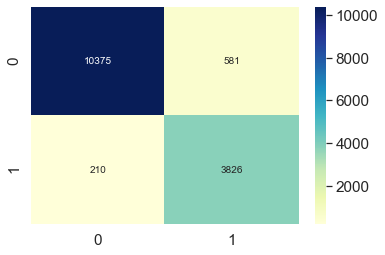

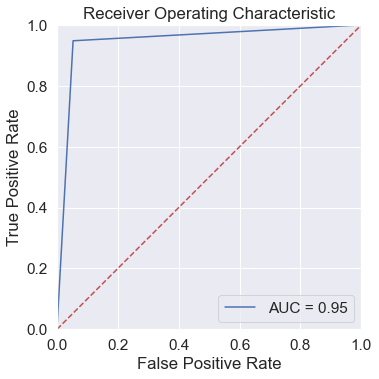

In [35]:
# model results
print(metrics.classification_report(Y_test, Y_lstm.reshape(len(Y_lstm)), digits=3))
plot_confussion_matrix(Y_test, Y_lstm.reshape(len(Y_lstm)))
plot_roc_curve(Y_test, Y_lstm.reshape(len(Y_lstm)))

### a.1.2: Bert-SVM

In [36]:
# importing pretrained bert from 'bert-base-uncased'
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [38]:
def bert_text_preparation(headline, body, tokenizer):
    marked_text = headline + " [SEP]" + body
    marked_text = marked_text[:500] + " [SEP]"
    indexed_tokens = tokenizer.encode(marked_text,
                                      add_special_tokens=False,
                                      max_length=512,
                                      padding='max_length')
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    return tokens_tensor, segments_tensors

In [39]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2][1:]
    token_embeddings = hidden_states[-1]
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]
    return list_token_embeddings

In [40]:
def bert_embedding(data):
    token_embedding = []
    for i in data.index:
        headline = data['Headline'][i]
        body = data['articleBody'][i]
        tokens_tensor, segments_tensors = bert_text_preparation(headline, body, tokenizer)
        list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, bert)
        token_embedding.append(list_token_embeddings)
    token_embedding = np.array(token_embedding)
    return token_embedding

In [41]:
X_train_sample = X_train[:1000]

In [42]:
X_train_bert = bert_embedding(X_train_sample)

In [43]:
X_val_sample = X_val[:1000]

In [44]:
X_val_bert = bert_embedding(X_val_sample)

In [45]:
X_test_sample = X_test[:1000]

In [46]:
X_test_bert = bert_embedding(X_test_sample)

In [47]:
Y_train_sample = Y_train[:1000]
Y_val_sample = Y_val[:1000]
Y_test_sample = Y_test[:1000]

In [48]:
X_train_mpool = X_train_bert[:,0,]
X_val_mpool = X_val_bert[:,0,]
X_test_mpool = X_test_bert[:,0,]

In [49]:
# Building the SVM model
# input the max pooling input
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model3 = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model3.fit(X_train_mpool, Y_train_sample)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

              precision    recall  f1-score   support

           0       0.77      0.54      0.63       744
           1       0.28      0.53      0.37       256

    accuracy                           0.54      1000
   macro avg       0.52      0.53      0.50      1000
weighted avg       0.64      0.54      0.56      1000



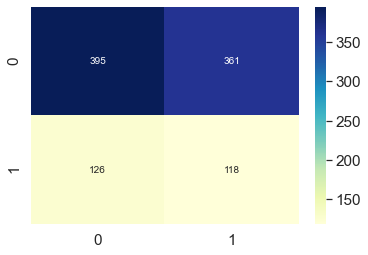

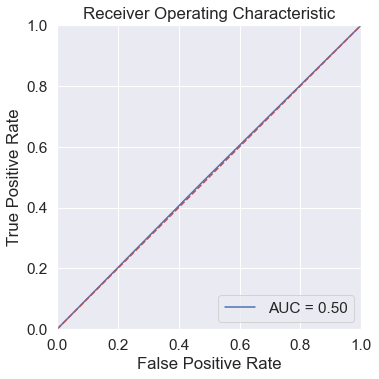

In [50]:
# predicting the test data
Y_svm = model3.predict(X_train_mpool)
print(metrics.classification_report(Y_test_sample, Y_svm))
plot_confussion_matrix(Y_val_sample, Y_svm)
plot_roc_curve(Y_val_sample, Y_svm)

### a.2.2: Bert-LSTM

In [51]:
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model4 = keras.models.Sequential()
model4.add(keras.layers.LSTM(768,
                            input_shape=(None, 768),
                            return_sequences=True))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(1, activation='sigmoid'))
model4.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
model4.fit(X_train_bert, Y_train_sample, 
           validation_data=(X_val_bert, Y_val_sample),
           epochs=5, batch_size=8, verbose=1)

Epoch 1/5
125/125 [==============================] - 747s 6s/step - loss: 0.7499 - accuracy: 0.5079 - val_loss: 0.7878 - val_accuracy: 0.2727
Epoch 2/5
125/125 [==============================] - 720s 6s/step - loss: 0.6968 - accuracy: 0.5047 - val_loss: 0.7060 - val_accuracy: 0.3094
Epoch 3/5
125/125 [==============================] - 721s 6s/step - loss: 0.6782 - accuracy: 0.5567 - val_loss: 0.5763 - val_accuracy: 0.7574
Epoch 4/5
125/125 [==============================] - 729s 6s/step - loss: 0.6534 - accuracy: 0.6258 - val_loss: 0.7778 - val_accuracy: 0.4707
Epoch 5/5
125/125 [==============================] - 727s 6s/step - loss: 0.5912 - accuracy: 0.7125 - val_loss: 0.4629 - val_accuracy: 0.8049


              precision    recall  f1-score   support

           0      0.872     0.836     0.854       744
           1      0.575     0.645     0.608       256

    accuracy                          0.787      1000
   macro avg      0.724     0.740     0.731      1000
weighted avg      0.796     0.787     0.791      1000



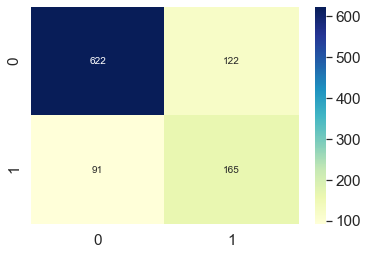

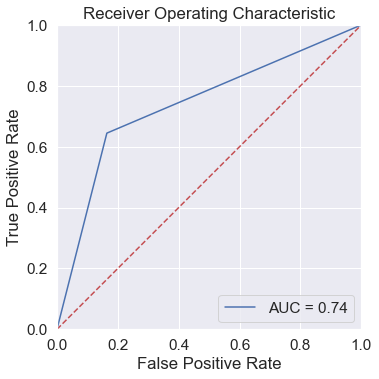

In [87]:
# model results
Y_pred = model4.predict_classes(X_test_bert)
Y_pred = Y_pred.mean(axis=1)
Y_pred = np.rint(Y_pred)
print(metrics.classification_report(Y_test_sample, Y_pred, digits=3))
plot_confussion_matrix(Y_test_sample, Y_pred)
plot_roc_curve(Y_test_sample, Y_pred)

### Task 2 preparation

In [185]:
# defining a fuction to prepare data for multiclass classification
def prepare_stance(data):
    df = data
    related = {'agree': 1,
               'discuss': 2,
               'disagree': 3,
               'unrelated': 0}
    df['Stance'] = df['Stance'].replace(related)
    df = df.drop(df[df['Stance']==0].index)
    y = df[['Stance']]
    x = df[['Headline', 'articleBody']]
    return x, y

In [186]:
X_train, Y_train = prepare_stance(train)
X_val, Y_val = prepare_stance(val)
X_test, Y_test = prepare_stance(test)

In [187]:
# data cleaning
X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [188]:
# resampling the train data using random under samplier
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

In [189]:
Y_val = Y_val['Stance']
Y_test = Y_test['Stance']

1    474
2    474
3    474
Name: Stance, dtype: int64

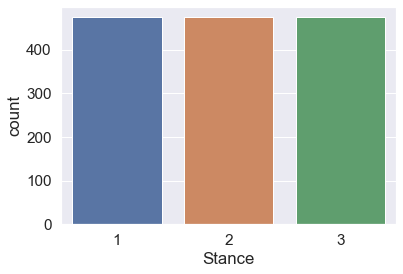

In [190]:
# ploting out classes in the train data
sn.countplot(x=Y_train)
Y_train.value_counts()

In [191]:
# implimenting one-hot encoding on the classes
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_test = pd.get_dummies(Y_test)

In [192]:
# creating tfidf vectors
X_train_tfidf = stack_tfidf(X_train)
X_val_tfidf = stack_tfidf(X_val)
X_test_tfidf = stack_tfidf(X_test)

### b: TDIF-LSTM

In [193]:
# preparing input for LSTM model
X_train_tfidf, Y_train = prepare_lstm(X_train_tfidf, Y_train)
X_val_tfidf, Y_val = prepare_lstm(X_val_tfidf, Y_val)
X_test_tfidf, Y_test = prepare_lstm(X_test_tfidf, Y_test)

In [194]:
# matching y dimension with model output
Y_train = Y_train[:,None,:]
Y_val = Y_val[:,None,:]
Y_tets = Y_test[:,None,:]

In [195]:
X_train_tfidf.shape

(1422, 1, 1000)

In [196]:
Y_train.shape

(1422, 1, 3)

In [126]:
# building multiclass LSTM model
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model5 = keras.models.Sequential()
model5.add(keras.layers.LSTM(1000,
                            input_shape=(None, 1000),
                            return_sequences=True))
model5.add(keras.layers.Dropout(0.3))
model5.add(keras.layers.Dense(3, activation='softmax'))
model5.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
model5.fit(X_train_tfidf, Y_train, 
           validation_data=(X_val_tfidf, Y_val),
           epochs=6, batch_size=8, verbose=1)

Epoch 1/6
178/178 [==============================] - 6s 34ms/step - loss: 0.8920 - accuracy: 0.6132 - val_loss: 0.7394 - val_accuracy: 0.6872
Epoch 2/6
178/178 [==============================] - 6s 33ms/step - loss: 0.6008 - accuracy: 0.7567 - val_loss: 0.7083 - val_accuracy: 0.7076
Epoch 3/6
178/178 [==============================] - 6s 33ms/step - loss: 0.4547 - accuracy: 0.8277 - val_loss: 0.6847 - val_accuracy: 0.7290
Epoch 4/6
178/178 [==============================] - 6s 33ms/step - loss: 0.3759 - accuracy: 0.8544 - val_loss: 0.8287 - val_accuracy: 0.7027
Epoch 5/6
178/178 [==============================] - 6s 33ms/step - loss: 0.3179 - accuracy: 0.8833 - val_loss: 0.8020 - val_accuracy: 0.7252
Epoch 6/6
178/178 [==============================] - 6s 33ms/step - loss: 0.2718 - accuracy: 0.8973 - val_loss: 0.8507 - val_accuracy: 0.7322


In [197]:
# predicting test data
Y_lstm = model5.predict_classes(X_test_tfidf)
Y_lstm = Y_lstm+1
Y_lstm = Y_lstm.reshape(len(Y_lstm))

In [208]:
# creating a comaprer for the predicted data
Y_true = test.drop(test[test['Stance']==0].index)
Y_true = Y_true['Stance']
Y_true = np.array(Y_true)

              precision    recall  f1-score   support

           1      0.610     0.623     0.616      1113
           2      0.904     0.764     0.828      2686
           3      0.266     0.705     0.386       237

    accuracy                          0.722      4036
   macro avg      0.593     0.697     0.610      4036
weighted avg      0.785     0.722     0.744      4036



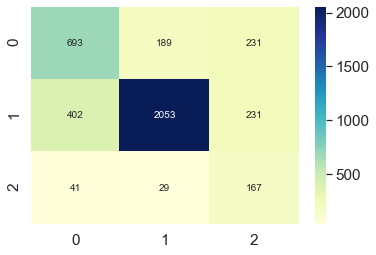

In [209]:
print(metrics.classification_report(Y_true, Y_lstm, digits=3))
plot_confussion_matrix(Y_true, Y_lstm)

### c: Finalised model

In [210]:
# creating a compy of test data
test_fn = test

In [211]:
# replacing text clasification with numbers
relation = {'agree': 1,
           'discuss': 2,
           'disagree': 3,
           'unrelated': 0}
test_fn['Stance'] = test_fn['Stance'].replace(relation)

In [212]:
# preparing x input for LSTM model
X_test = test_fn[['Headline', 'articleBody']]
X_test = clean_data(X_test)
X_test_tfidf = stack_tfidf(X_test)
X_test_tfidf = X_test_tfidf.toarray()
X_test_tfidf = X_test_tfidf[:, None, :]

<ipython-input-172-7044a453f4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = [clean_text(i) for i in data['Headline']]
<ipython-input-172-7044a453f4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['articleBody'] = [clean_text(i) for i in data['articleBody']]


In [213]:
# using the model previously trained on part a.2.1 to make a binary prediction
Y_pred = model2.predict_classes(X_test_tfidf)
Y_pred = Y_pred.reshape(len(Y_pred))

In [214]:
# appending the result the test dataframe
test_fn['prediction'] = Y_pred
test_fn = test_fn.sort_values(by='prediction')
test_fn

,Headline,Body ID,Stance,articleBody,prediction
38740,Militant Group Says It Killed American Journal...,2261,0,From the midweek edition of the Morning Jolt:\...,0
30369,"In New York City, Marijuana May Mean Ticket, N...",269,0,Islamic State militants have released a video ...,0
883,Lawmaker Says ‘At Least 10′ Islamic State Figh...,570,0,"You want a gold Apple Watch, you say? Then it'...",0
29418,Meteorite Leaves House-Sized Crater in Nicarag...,649,0,A student has broken a 19-year silence and rev...,0
21742,Lebanon detains wife and son of Al-Baghdadi,365,0,A lot of folks are buzzing about 17-year-old S...,0
...,...,...,...,...,...
20381,Strange mark turns out to be tropical spider b...,2338,2,AUSTRALIA — A man in Australia has been dubbed...,1
40527,Pentagon confirms al-Shabab leader killed in a...,1610,1,"Ahmed Abdi Godane — the leader of al Shabab, t...",1
48262,BATMAN VS. SUPERMAN BATMOBILE STOLEN,2135,2,Rumours that the Caped Crusader's ride has bee...,1
19459,CNN Broadcasts Purported Audio Containing Guns...,2220,2,An unverified audio recording that may have ca...,1


In [215]:
# spliting the data by prediction result
test_fn_related = test_fn.loc[test_fn['prediction']==1]
test_fn_unrelated = test_fn.loc[test_fn['prediction']==0] 

In [216]:
# taking the related prediction result from the fisrt model to prepare an imput for the second model
X_test = test_fn_related[['Headline', 'articleBody']]
X_test = clean_data(X_test)
X_test_tfidf = stack_tfidf(X_test)
X_test_tfidf = X_test_tfidf.toarray()
X_test_tfidf = X_test_tfidf[:, None, :]

<ipython-input-172-7044a453f4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = [clean_text(i) for i in data['Headline']]
<ipython-input-172-7044a453f4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['articleBody'] = [clean_text(i) for i in data['articleBody']]


In [217]:
# making sentiment prediction using the model from part b
Y_pred_class = model5.predict_classes(X_test_tfidf)

In [218]:
# preparing the model output for evaluation
Y_pred_class = Y_pred_class.reshape(len(Y_pred_class))
Y_pred_class = Y_pred_class + 1
test_fn_related['prediction'] = Y_pred_class

<ipython-input-218-419aea9f1209>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_fn_related['prediction'] = Y_pred_class


In [219]:
test_fn = pd.concat([test_fn_unrelated, test_fn_related], axis=0)
test_fn

,Headline,Body ID,Stance,articleBody,prediction
38740,Militant Group Says It Killed American Journal...,2261,0,From the midweek edition of the Morning Jolt:\...,0
30369,"In New York City, Marijuana May Mean Ticket, N...",269,0,Islamic State militants have released a video ...,0
883,Lawmaker Says ‘At Least 10′ Islamic State Figh...,570,0,"You want a gold Apple Watch, you say? Then it'...",0
29418,Meteorite Leaves House-Sized Crater in Nicarag...,649,0,A student has broken a 19-year silence and rev...,0
21742,Lebanon detains wife and son of Al-Baghdadi,365,0,A lot of folks are buzzing about 17-year-old S...,0
...,...,...,...,...,...
20381,Strange mark turns out to be tropical spider b...,2338,2,AUSTRALIA — A man in Australia has been dubbed...,3
40527,Pentagon confirms al-Shabab leader killed in a...,1610,1,"Ahmed Abdi Godane — the leader of al Shabab, t...",2
48262,BATMAN VS. SUPERMAN BATMOBILE STOLEN,2135,2,Rumours that the Caped Crusader's ride has bee...,1
19459,CNN Broadcasts Purported Audio Containing Guns...,2220,2,An unverified audio recording that may have ca...,2


In [220]:
Y_true = test_fn['Stance']
Y_pred_all = test_fn['prediction']

              precision    recall  f1-score   support

           0      0.980     0.947     0.963     10956
           1      0.493     0.573     0.530      1113
           2      0.822     0.738     0.777      2686
           3      0.228     0.675     0.340       237

    accuracy                          0.877     14992
   macro avg      0.631     0.733     0.653     14992
weighted avg      0.904     0.877     0.888     14992



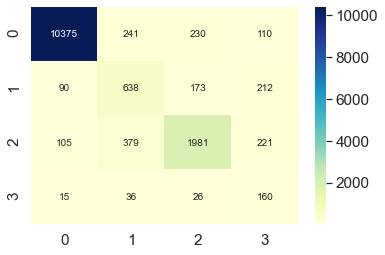

In [221]:
# final model results
print(metrics.classification_report(Y_true, Y_pred_all, digits=3))
plot_confussion_matrix(Y_true, Y_pred_all)